In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import geopy
from geopy import *

import matplotlib
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#
#Critical Gases
ozone_data = pd.read_csv("daily2016/daily_44201_2016.csv")
co_data = pd.read_csv("daily2016/daily_42101_2016.csv")

#Particulates
pm25_data = pd.read_csv("daily2016/daily_88101_2016.csv") 
pm10_data = pd.read_csv("daily2016/daily_81102_2016.csv")

#Meterological
temp_data = pd.read_csv("daily2016/daily_TEMP_2016.csv")
press_data = pd.read_csv("daily2016/daily_PRESS_2016.csv")
wind_data = pd.read_csv("daily2016/daily_WIND_2016.csv")
rh_dp_data = pd.read_csv("daily2016/daily_RH_DP_2016.csv")

In [3]:
#separate vars
windspd_data = wind_data.loc[wind_data['Parameter Code']==61103] # wind speed
winddir_data = wind_data.loc[wind_data['Parameter Code']==61104] # wind direction
rh_data = rh_dp_data.loc[rh_dp_data['Parameter Code']==62201] # rel humidity

In [4]:
#Turn a place name (ex. "Seattle, Washington") into longitude and latitude
def LongLatFromText(location):
    geolocator = Nominatim()
    coded_location = geolocator.geocode(location)
    return (coded_location.longitude, coded_location.latitude)

#Calculate a bounding box around location with a default of 10 miles
def BoundingBox(lng,lat,dist=10.0) :
    #1 deg = 69 mi (or 111 km)
    delta = dist / 69.0  
    return (lng-delta, lat-delta, lng+delta, lat+delta)

#Find Sites within the bounding box
def InBB(llng, llat, ulng, ulat, row) :
    testlng = float(row['Longitude'])
    testlat = float(row['Latitude'])
    return (llng < testlng < ulng) and (llat < testlat < ulat)

In [5]:
commonradius = 20.0
place1 = 'seattle,wa'
lng , lat = LongLatFromText(place1)
llng, llat, ulng, ulat = BoundingBox(lng,lat,commonradius)

pm25_seattle = pm25_data[pm25_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
pm10_seattle = pm10_data[pm10_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
ozone_seattle = ozone_data[ozone_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
co_seattle = co_data[co_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
temp_seattle = temp_data[temp_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
press_seattle = press_data[press_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
windspd_seattle = windspd_data[windspd_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
winddir_seattle = winddir_data[winddir_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]
rh_seattle = rh_data[rh_data.apply(lambda row: InBB(llng,llat,ulng,ulat,row), axis=1)]

In [6]:
# 
#check sizes
print ('pm25',pm25_seattle.shape)
print ('pm10',pm10_seattle.shape)
print ('ozone',ozone_seattle.shape)
print ('co',co_seattle.shape)
print ('temp',temp_seattle.shape)
print ('press',press_seattle.shape)
print ('windspd',windspd_seattle.shape)
print ('winddir',winddir_seattle.shape)
print ('rh',rh_seattle.shape)

pm25 (2743, 29)
pm10 (0, 29)
ozone (413, 29)
co (994, 29)
temp (533, 29)
press (274, 29)
windspd (533, 29)
winddir (533, 29)
rh (274, 29)


In [7]:
def AvgandStrip(in_data,nname) :
    sf = in_data['Arithmetic Mean'].groupby([in_data['Date Local']]).mean()
    out_data = pd.DataFrame({'Date Local':sf.index, nname:sf.values})
    out_data = out_data.set_index('Date Local')
    return out_data


pm25_sea = AvgandStrip(pm25_seattle,'pm25')
pm10_sea = AvgandStrip(pm10_seattle,'pm10')
ozone_sea = AvgandStrip(ozone_seattle,'ozone')
co_sea = AvgandStrip(co_seattle,'co')
temp_sea = AvgandStrip(temp_seattle,'temp')
press_sea = AvgandStrip(press_seattle,'press')
windspd_sea = AvgandStrip(windspd_seattle,'windspd')
winddir_sea = AvgandStrip(winddir_seattle,'winddir')
rh_sea = AvgandStrip(rh_seattle,'rh')

In [8]:
#check one
pm25_sea.head()


,pm25
Date Local,
2016-01-01,19.659470
2016-01-02,17.730000
2016-01-03,9.466667
2016-01-04,9.073106
2016-01-05,12.888750


In [10]:
# pm10 has no sites in SEA so leave them out
concat_sea = pd.concat([pm25_sea,ozone_sea,co_sea,temp_sea,press_sea,windspd_sea, 
                       winddir_sea,rh_sea],axis=1)

concat_sea = concat_sea.apply(pd.Series.interpolate)
concat_sea = concat_sea.dropna()
concat_sea.head(5)

,pm25,ozone,co,temp,press,windspd,winddir,rh
2016-01-01,19.659470,0.010833,0.663794,35.208333,1015.583333,1.695833,160.291667,63.083333
2016-01-02,17.730000,0.017000,0.695823,34.729167,1009.208333,1.435417,153.708333,60.000000
2016-01-03,9.466667,0.018792,0.405967,36.270833,1001.958333,2.106250,179.520833,62.458333
2016-01-04,9.073106,0.008833,0.387059,36.125000,994.416667,2.304167,133.125000,98.750000
2016-01-05,12.888750,0.001958,0.572962,39.604167,989.375000,1.714584,125.437500,99.375000


In [11]:
from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = matplotlib.pyplot.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

/Users/yamaoka/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


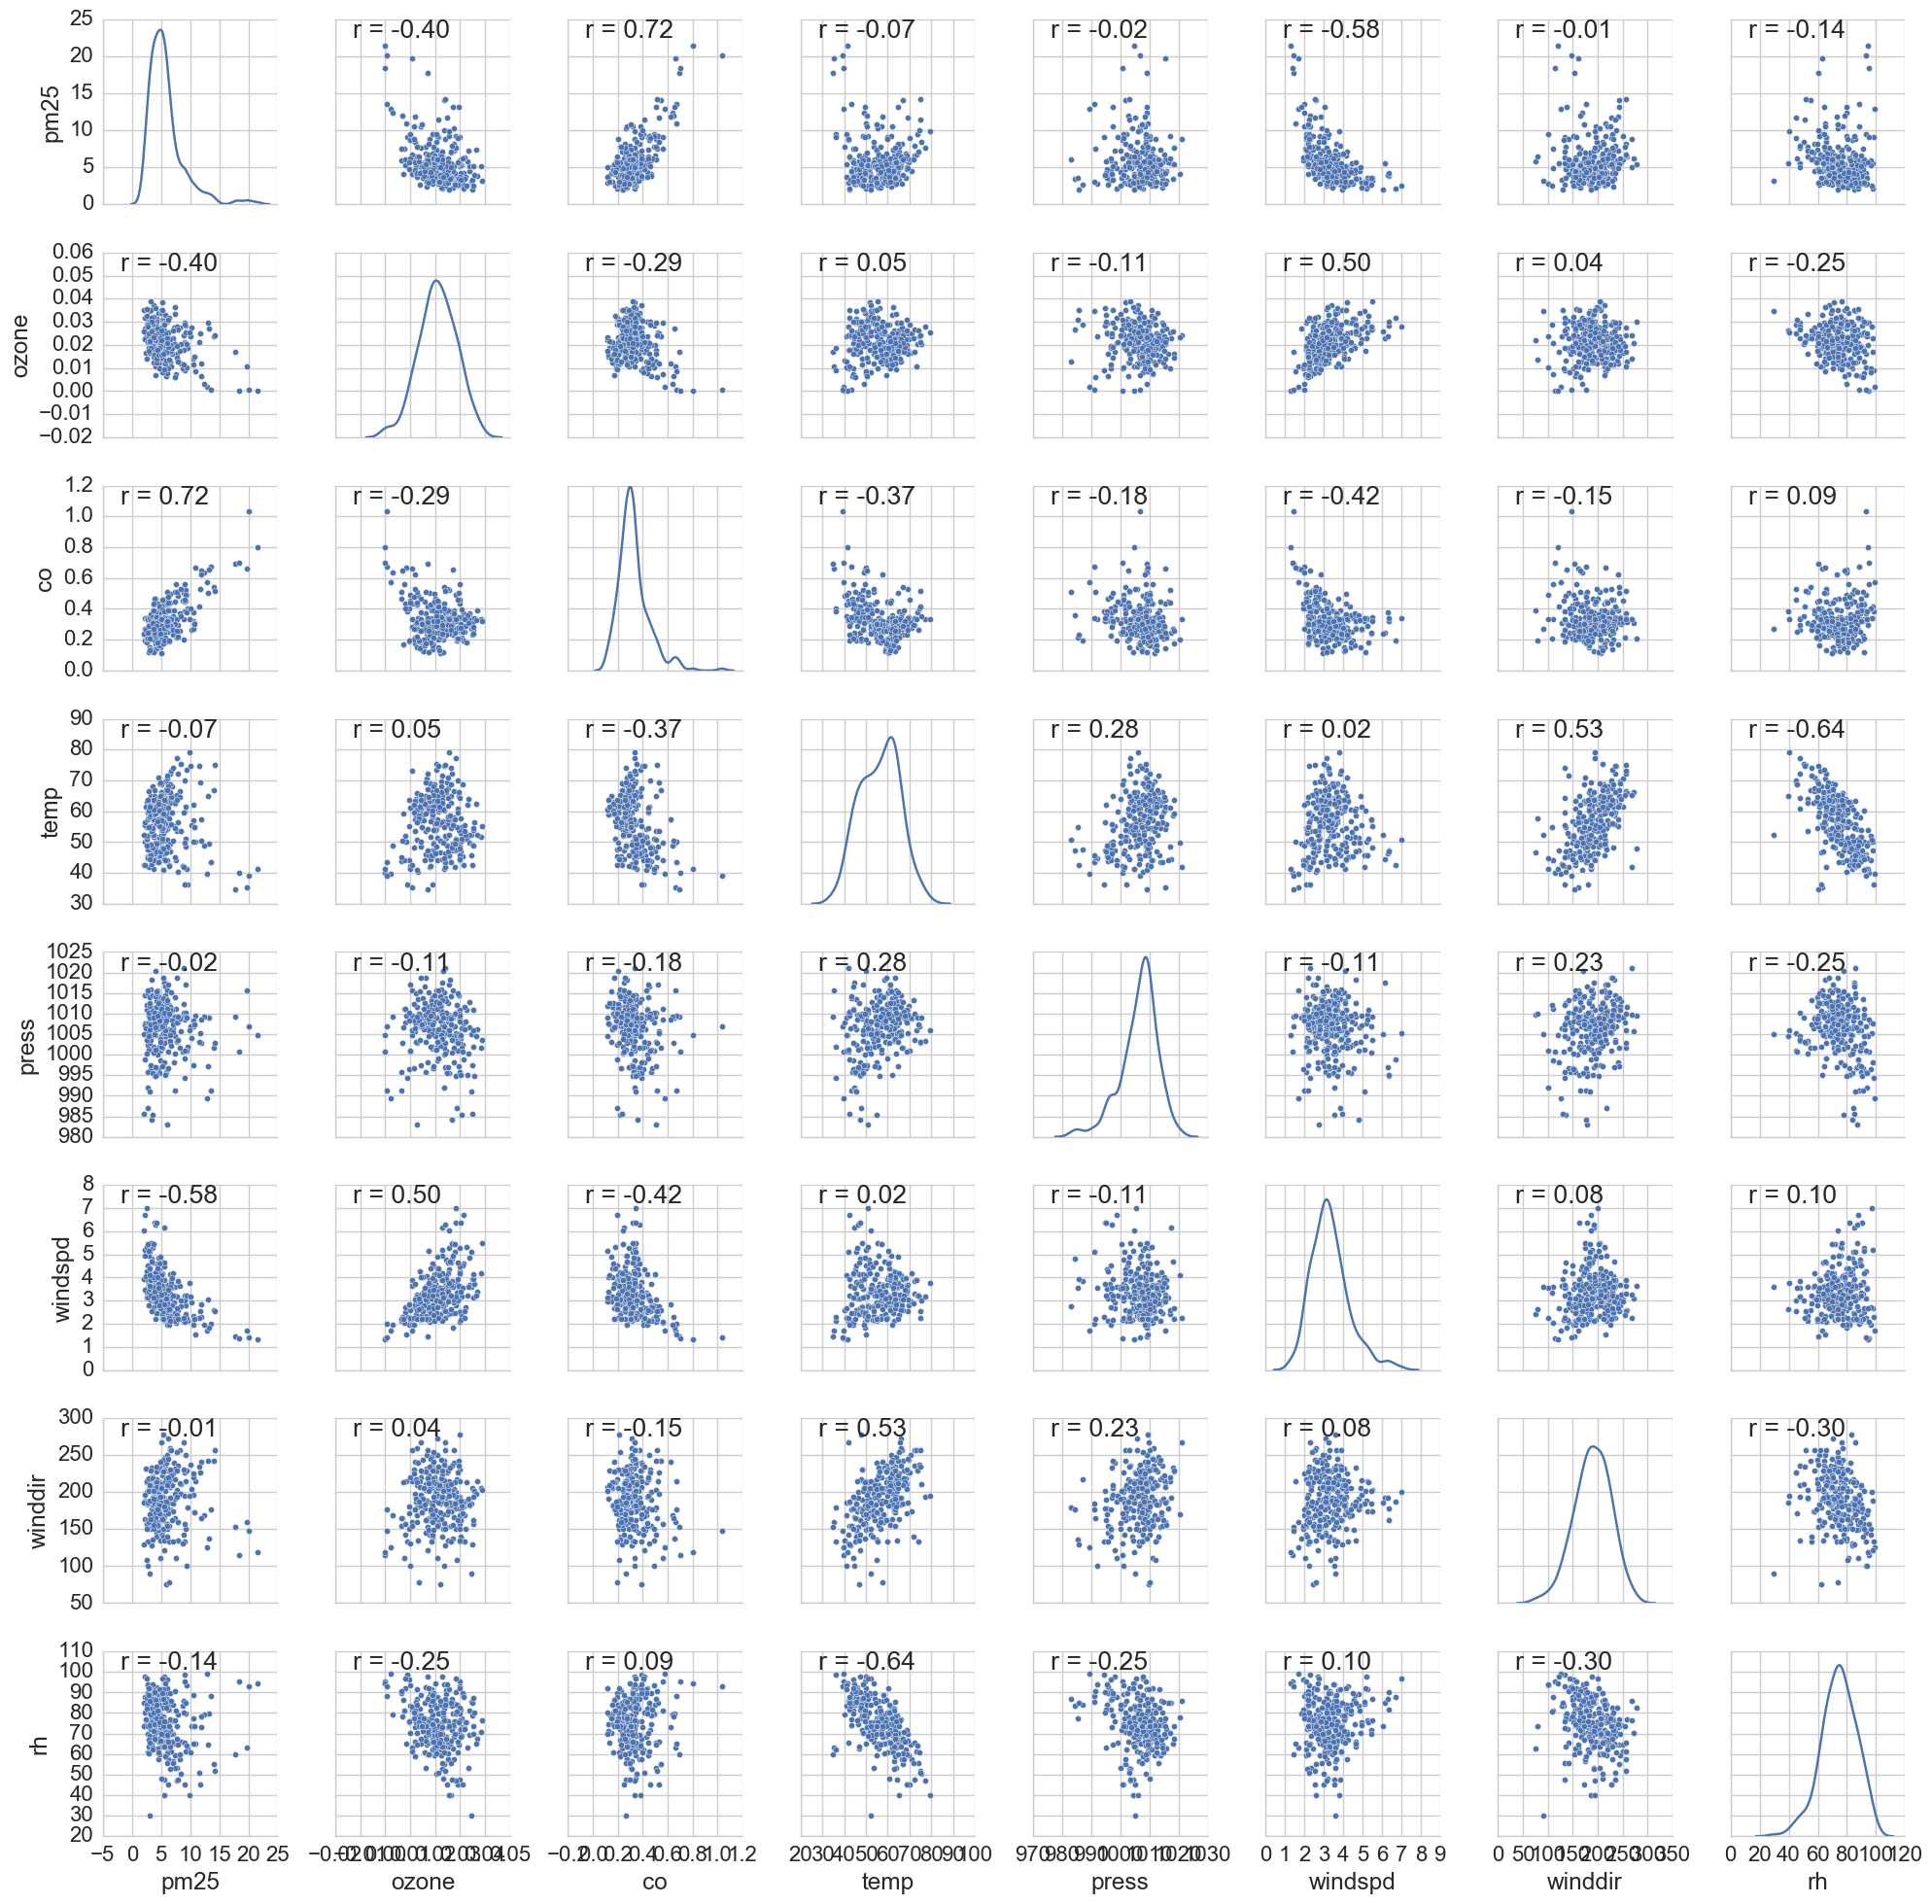

In [13]:
sns.set(style = 'whitegrid',font_scale=1.6)

sea_correlations = sns.pairplot(concat_sea,diag_kind='kde')

sea_correlations.map_upper(corrfunc)
sea_correlations.map_lower(corrfunc)

In [14]:
from sklearn import cross_validation,ensemble,metrics

y_data = concat_sea['pm25']
x_data = concat_sea.drop(['pm25','co','ozone'],1) # only use weather data
col_names = concat_sea.drop(['pm25','co','ozone'],1).keys()

X_train, X_test, y_train, y_test = cross_validation.train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.18,
                                                    random_state=4)

/Users/yamaoka/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
#
# Try linear regression
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Coefficients: 
 [-0.06928515 -0.04743151 -1.82253196  0.01072755 -0.04262515]
Mean squared error: 8.60
Variance score: 0.36


In [16]:
#
#try GradientBoostingRegressor
parameters = {
              'n_estimators': 30, 
              'max_depth': 5, 
              'learning_rate': 0.1, 
              'loss': 'huber'
             }

classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
mse = metrics.mean_squared_error(y_test, predictions)
print('Mean Squared Error: {:.3f}'.format(mse))

Mean Squared Error: 2.873


/Users/yamaoka/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function staged_decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


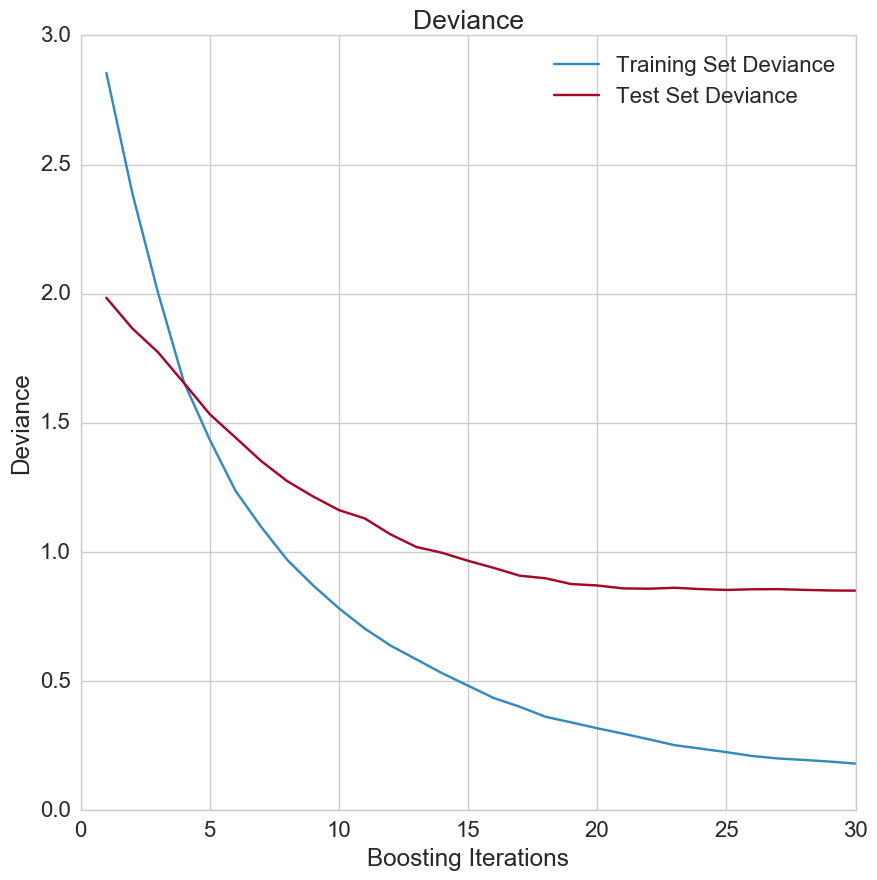

In [17]:
test_score = [classifier.loss_(y_test, y_pred) for y_pred in classifier.staged_decision_function(X_test)]

matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.title('Deviance');
matplotlib.pyplot.plot(numpy.arange(parameters['n_estimators']) + 1, classifier.train_score_, c='#348ABD',
         label='Training Set Deviance');
matplotlib.pyplot.plot(numpy.arange(parameters['n_estimators']) + 1, test_score, c='#A60628',
         label='Test Set Deviance');
#matplotlib.pyplot.axvline(20,label='Overfit Point')
matplotlib.pyplot.legend(loc='upper right');
matplotlib.pyplot.xlabel('Boosting Iterations');
matplotlib.pyplot.ylabel('Deviance');

In [19]:
parameters = {
              'n_estimators': 5, 
              'max_depth': 5, 
              'learning_rate': 0.1, 
              'loss': 'huber'
             }
classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
mse = metrics.mean_squared_error(y_test, predictions)
print('Mean Squared Error: {:.3f}'.format(mse))

Mean Squared Error: 8.112
